In [23]:
import geopandas as gpd
import pandas as pd
import networkx as nx
from shapely.geometry import Point, LineString
import numpy as np
import matplotlib.pyplot as plt
import jenkspy
import math

In [24]:
trajectory_df = gpd.read_file('./data/nanshan_traj.shp').to_crs(epsg=4326)
n_sample = 100 # the number you need
trajectory_sample = trajectory_df.iloc[:n_sample]

In [25]:
road_df = gpd.read_file('./data/nanshan_road.shp')

In [26]:
def nearest_node(graph, point):
    """
    Find the nearest node in the graph to a given point.
    
    Parameters:
    - graph: A networkx graph where nodes are tuples of (x, y) coordinates.
    - point: A shapely.geometry.Point object representing the location to find the nearest node for.
    
    Returns:
    - The node (as a tuple of (x, y)) in the graph that is nearest to the given point.
    """
    # turn point into as simple tuple
    point_coords = (point.x, point.y)
    
    # calculate distance between this coordinate and given point
    distances = {node: np.sqrt((node[0] - point_coords[0])**2 + (node[1] - point_coords[1])**2) for node in graph.nodes}
    nearest_node = min(distances, key=distances.get)
    
    return nearest_node

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))

    r = 6371

    return c * r * 1000

In [27]:
# create road network graph
G = nx.Graph()
for index, row in road_df.iterrows():
    len_coords = len(row['geometry'].coords)
    for i in range(len_coords-1):
        start_point = row['geometry'].coords[i]
        end_point = row['geometry'].coords[i+1]
        l = haversine(start_point[0], start_point[1], end_point[0], end_point[1])/100
        G.add_edge(start_point, end_point, weight=1, length=l, composite = 1+l)  

In [28]:
def update_edge_weights(graph, flow):
    for edge in graph.edges:
        # base_weight = graph[edge[0]][edge[1]].get('weight', 1)
        new_weight = flow[edge]
        graph[edge[0]][edge[1]]['weight'] = new_weight

def calculate_composite_weight(edge_weight, length_weight=1.0):
    return edge_weight + length_weight

def traffic_assignment(graph, trajectory_df, convergence_threshold=0.01):
    flow = {edge: 1 for edge in graph.edges}
    converged = False
    iteration = 0
    max_iterations = 1000  # set max iterations
    previous_total_flow = None

    while not converged and iteration < max_iterations:
        # reset flow
        current_total_flow = 0

        for edge in flow:
            flow[edge] = graph[edge[0]][edge[1]].get('weight', 1)
        
        # distribute and update flow
        for index, row in trajectory_df.iterrows():
            start_point = Point(row['geometry'].coords[0])
            end_point = Point(row['geometry'].coords[-1])
            start_nearest = nearest_node(graph, start_point)
            end_nearest = nearest_node(graph, end_point)
            try:
                path = nx.shortest_path(graph, source=start_nearest, target=end_nearest, weight='composite')
            except nx.NetworkXNoPath:
                print("no path")
                continue
            for i in range(len(path) - 1):
                edge = (path[i], path[i+1])
                if edge in flow:
                    flow[edge] += 1
                elif (edge[1], edge[0]) in flow:  # Check the reverse direction for undirected graphs
                    flow[(edge[1], edge[0])] += 1
                current_total_flow += 1

        update_edge_weights(graph, flow)

        for _, _, data in graph.edges(data=True):
            length_weight = data['length']
            composite_weight = calculate_composite_weight(data['weight'], length_weight)
            data['composite'] = composite_weight

        if previous_total_flow is not None:
            flow_change = abs(current_total_flow - previous_total_flow) / previous_total_flow
            print(current_total_flow,previous_total_flow,flow_change)
            if flow_change < convergence_threshold:
                converged = True
                print("Converged!")
        
        previous_total_flow = current_total_flow
        iteration += 1
        print(iteration)

    return graph

In [29]:
G_weight = traffic_assignment(G, trajectory_sample, convergence_threshold=0.05)

no path
no path
1
no path
no path
5916 4364 0.3556370302474794
2
no path
no path
6760 5916 0.14266396213657878
3
no path
no path
7147 6760 0.05724852071005917
4
no path
no path
7078 7147 0.00965440044774031
Converged!
5


In [30]:
nx.write_gexf(G_weight, "./data/G_weighted.gexf")

In [31]:
G_weight = nx.read_gexf("./data/G_weighted.gexf")

In [32]:
nanshan_gdf = gpd.read_file('./data/nanshan_grid.shp')

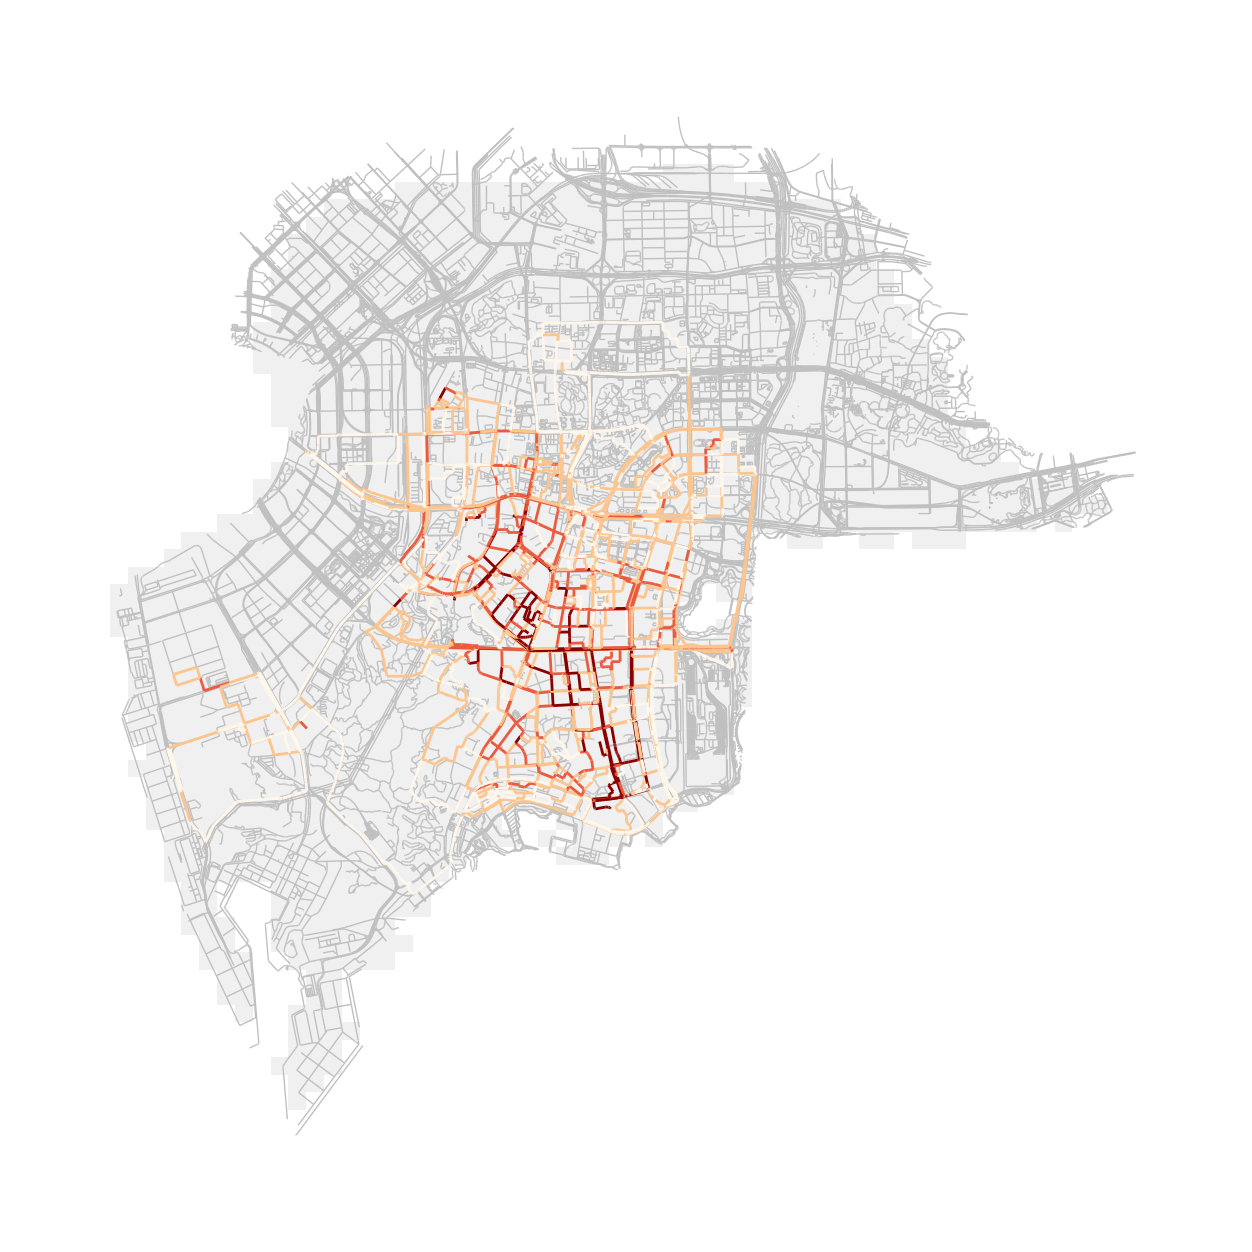

In [36]:
pos = {k: eval(v) for k, v in {node: node for node in G_weight.nodes()}.items()}
edges, weights = zip(*nx.get_edge_attributes(G_weight, 'weight').items())

fig, ax = plt.subplots(figsize=(20, 16))
nanshan_gdf.plot(ax=ax, color='#f0f0f0')

# First, draw edges with weight=1 in light grey and lower alpha
edges_weight_1 = [(u, v) for (u, v, w) in G_weight.edges(data=True) if w['weight'] == 1]
nx.draw_networkx_edges(G_weight, pos, ax=ax,edgelist=edges_weight_1, width=1, edge_color="silver", alpha=0.99)

# Extract edges with weight greater than 1 and their corresponding weights
edges_weight_gt_1 = [(u, v) for (u, v, w) in G_weight.edges(data=True) if w['weight'] > 1]
weights_gt_1 = [G_weight[u][v]['weight'] for u, v in edges_weight_gt_1] if edges_weight_gt_1 else []

# Use jenkspy to calculate natural breaks
num_buckets = 5
breaks = jenkspy.jenks_breaks(weights_gt_1, n_classes=num_buckets)

# Assign colors for each bin
bucket_indices = np.searchsorted(breaks, weights_gt_1, side='right') - 1
bucket_indices = np.clip(bucket_indices, 0, num_buckets-1)  # 确保索引在正确的范围内

# Assign colors for each bin
colors = [plt.cm.OrRd(i / (num_buckets-1)*1.3) for i in bucket_indices]
# colors = [plt.cm.coolwarm(i / (num_buckets-1)) for i in bucket_indices]

# Draw edges with weight greater than 1 using the assigned colors
if edges_weight_gt_1:
    nx.draw_networkx_edges(G_weight, pos,ax=ax, edgelist=edges_weight_gt_1, edge_color=colors, width=2)

# Display the figure
plt.axis('off')
plt.savefig('./img/road_dta.png', dpi=300, bbox_inches='tight')
plt.show()